In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


/Users/rashedkarim/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
df_data = pd.read_csv('./data/encirclement/PC_LPV_circle.csv')

In [3]:
df_data.describe()

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar
count,2033.000000,2033.000000,2033.000000,2033.000000,2033.000000,2033.000000,2033.000000
mean,59.269552,11028.350713,-5.619712,42.518684,42.185965,1.228234,51.100099
std,34.657167,1708.238468,11.205112,8.886443,5.969039,0.642223,22.262691
min,0.000000,7548.000000,-25.307500,27.609700,29.434600,0.000000,0.000000
25%,29.000000,9434.000000,-15.240900,33.869200,36.958800,1.000000,32.833300
50%,59.000000,11603.000000,-6.498280,42.778900,44.310500,1.000000,44.166700
75%,89.000000,12325.000000,5.438360,51.907600,46.795100,1.000000,72.500000
max,119.000000,13373.000000,12.881600,54.538700,50.519200,3.000000,98.714300


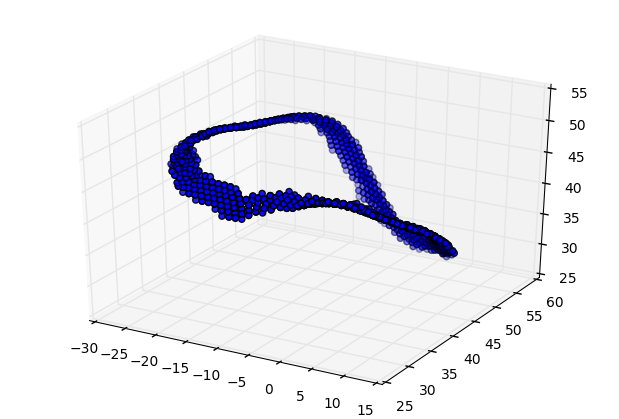

In [4]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_data['X'], df_data['Y'], df_data['Z'])
plt.show()

In [5]:
df_data_scalars = pd.concat([df_data['MainVertexSeq'], df_data['MeshScalar']], axis=1)

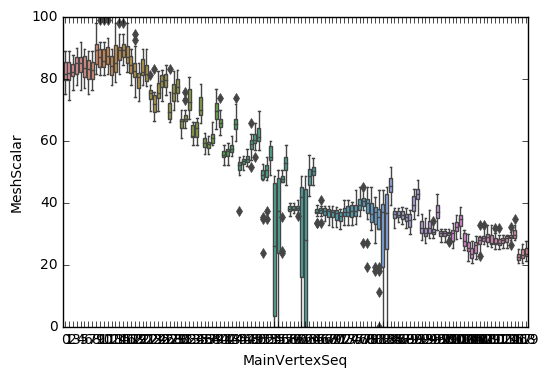

In [6]:
ax = sns.boxplot(x="MainVertexSeq", y="MeshScalar", data=df_data_scalars)

In [7]:
g1 = df_data.groupby(['MainVertexSeq']).median()
g1 = g1.reset_index()

In [8]:
g1.head(2)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar
0,0,7816.0,0.307178,52.8903,31.173,1.0,81.5000
1,1,7802.0,1.556750,52.8299,30.842,1.0,81.8333


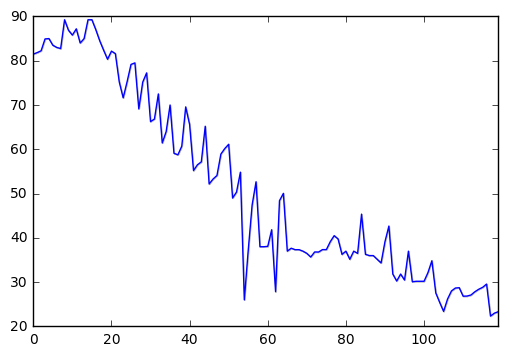

In [9]:
ax = sns.tsplot(data=g1['MeshScalar'])

In [10]:
center_data = [df_data['X'].mean(), df_data['Y'].mean(), df_data['Z'].mean()]

In [11]:
center_data

[-5.619711621298561, 42.518684062960965, 42.18596512543057]

In [12]:
df_data_scalars = pd.concat([df_data['MainVertexSeq'], df_data['MeshScalar']], axis=1)

In [13]:
g1 = df_data.groupby(['MainVertexSeq']).median()
g1 = g1.reset_index()

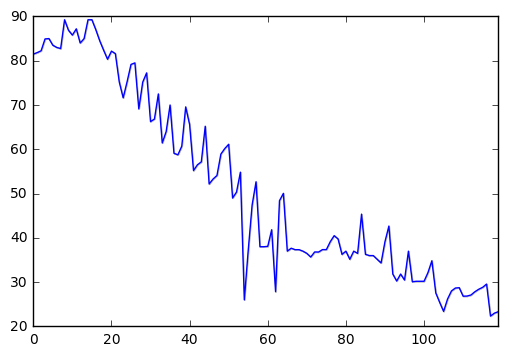

In [14]:
ax = sns.tsplot(data=g1['MeshScalar'])

In [15]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [16]:
def point_theta(center, A):
    thetas = []; 
    Ref_pt = [A.iloc[0]['X'], A.iloc[0]['Y'], A.iloc[0]['Z']] 
    for index, row in A.iterrows():
        pt = [row['X'], row['Y'], row['Z']]
        theta = angle_between(Ref_pt, pt)
        thetas.append(theta)
    return thetas


In [17]:
thetas = point_theta(center_data, df_data)

In [18]:
thetas_df = pd.Series(thetas, name='theta');

In [19]:
df_data_with_theta = pd.concat([df_data, thetas_df], axis=1)

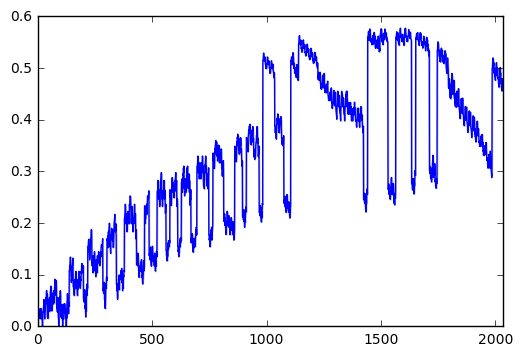

In [20]:
sns.tsplot(df_data_with_theta['theta'])

In [21]:
df_data_with_thetas_sorted = df_data_with_theta.sort_values(by='theta')

In [22]:
df_data_with_thetas_sorted.head(10)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
0,0,7800,0.527843,52.8903,31.1730,0,89.0,0.000000
1,0,7800,0.527843,52.8903,31.1730,3,89.0,0.000000
109,6,7800,0.527843,52.8903,31.1730,2,89.0,0.000000
125,7,7800,0.527843,52.8903,31.1730,1,89.0,0.000000
92,5,7800,0.527843,52.8903,31.1730,1,89.0,0.000000
21,1,7800,0.527843,52.8903,31.1730,1,89.0,0.000000
31,1,8051,0.307178,52.5698,32.0035,1,83.0,0.014718
15,0,8051,0.307178,52.5698,32.0035,1,83.0,0.014718
113,6,8051,0.307178,52.5698,32.0035,1,83.0,0.014718
93,5,8051,0.307178,52.5698,32.0035,1,83.0,0.014718


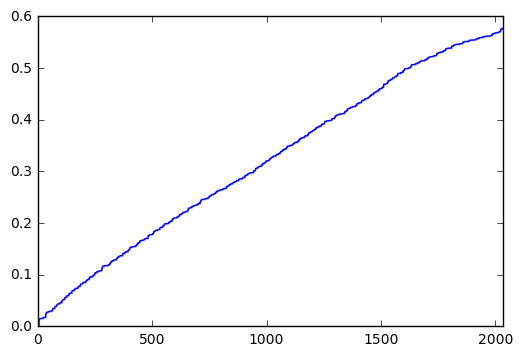

In [23]:
sns.tsplot(df_data_with_thetas_sorted['theta'])

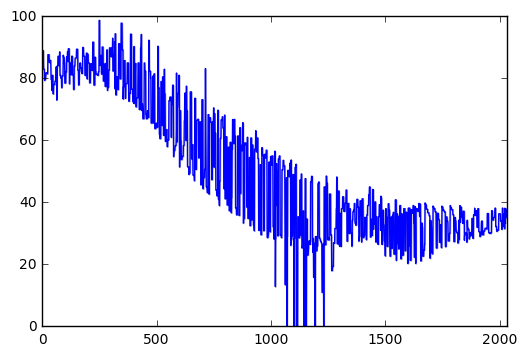

In [24]:
sns.tsplot(df_data_with_thetas_sorted['MeshScalar'])

In [25]:
df_data_with_thetas_sorted.head(15)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
0,0,7800,0.527843,52.8903,31.1730,0,89.0,0.000000
1,0,7800,0.527843,52.8903,31.1730,3,89.0,0.000000
109,6,7800,0.527843,52.8903,31.1730,2,89.0,0.000000
125,7,7800,0.527843,52.8903,31.1730,1,89.0,0.000000
92,5,7800,0.527843,52.8903,31.1730,1,89.0,0.000000
21,1,7800,0.527843,52.8903,31.1730,1,89.0,0.000000
31,1,8051,0.307178,52.5698,32.0035,1,83.0,0.014718
15,0,8051,0.307178,52.5698,32.0035,1,83.0,0.014718
113,6,8051,0.307178,52.5698,32.0035,1,83.0,0.014718
93,5,8051,0.307178,52.5698,32.0035,1,83.0,0.014718


In [26]:
df_data_with_thetas_sorted_nodupes = df_data_with_thetas_sorted.drop_duplicates(subset='VertexID', keep='last');

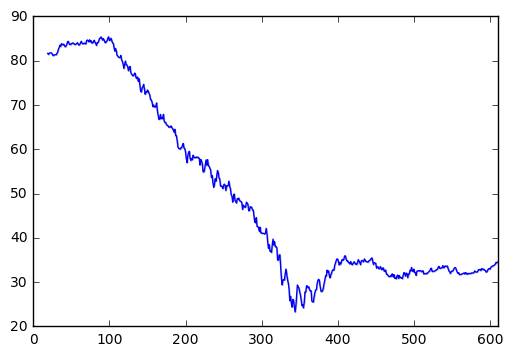

In [27]:
sns.tsplot(pd.rolling_mean(df_data_with_thetas_sorted_nodupes['MeshScalar'],20))

In [28]:
df_data_with_thetas_sorted_nodupes.describe()

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
count,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000
mean,60.743464,11092.119281,-5.855161,42.332157,42.405584,1.186275,49.732128,0.325193
std,34.605486,1704.206072,11.168901,8.928462,5.964877,0.531749,22.532758,0.163936
min,0.000000,7548.000000,-25.307500,27.609700,29.434600,0.000000,0.000000,0.000000
25%,30.000000,9643.750000,-15.662100,33.773375,37.207550,1.000000,31.575000,0.190894
50%,62.000000,11609.500000,-6.706870,42.563750,44.506300,1.000000,40.916650,0.334881
75%,90.250000,12508.250000,4.839375,51.794375,47.028150,1.000000,69.812500,0.469522
max,119.000000,13373.000000,12.881600,54.538700,50.519200,3.000000,98.714300,0.577260
